# Draft Paper on Fast Multitask GPs

## Setup

In [1]:
import fastgps
import torch
torch.set_default_dtype(torch.float64)
import qmcpy as qp
import numpy as np 
import time
import pandas as pd
import matplotlib
from matplotlib import pyplot
pyplot.style.use("seaborn-v0_8-whitegrid")
COLORS = ["xkcd:"+color[:-1] for color in pd.read_csv("../../../../xkcd_colors.txt",comment="#",header=None).iloc[:,0].tolist()][::-1]
pyplot.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=COLORS)
LINESTYLES = ['solid','dotted','dashed','dashdot',(0, (1, 1))]
MARKERS = ["o","D","s"]
DEFAULTFONTSIZE = 30
pyplot.rcParams['xtick.labelsize'] = DEFAULTFONTSIZE
pyplot.rcParams['ytick.labelsize'] = DEFAULTFONTSIZE
pyplot.rcParams['ytick.labelsize'] = DEFAULTFONTSIZE
pyplot.rcParams['axes.titlesize'] = DEFAULTFONTSIZE
pyplot.rcParams['figure.titlesize'] = DEFAULTFONTSIZE
pyplot.rcParams["axes.labelsize"] = DEFAULTFONTSIZE
pyplot.rcParams['legend.fontsize'] = DEFAULTFONTSIZE
pyplot.rcParams['font.size'] = DEFAULTFONTSIZE
pyplot.rcParams['lines.linewidth'] = 5
pyplot.rcParams['lines.markersize'] = 15
PW = 30 # inches

## Points

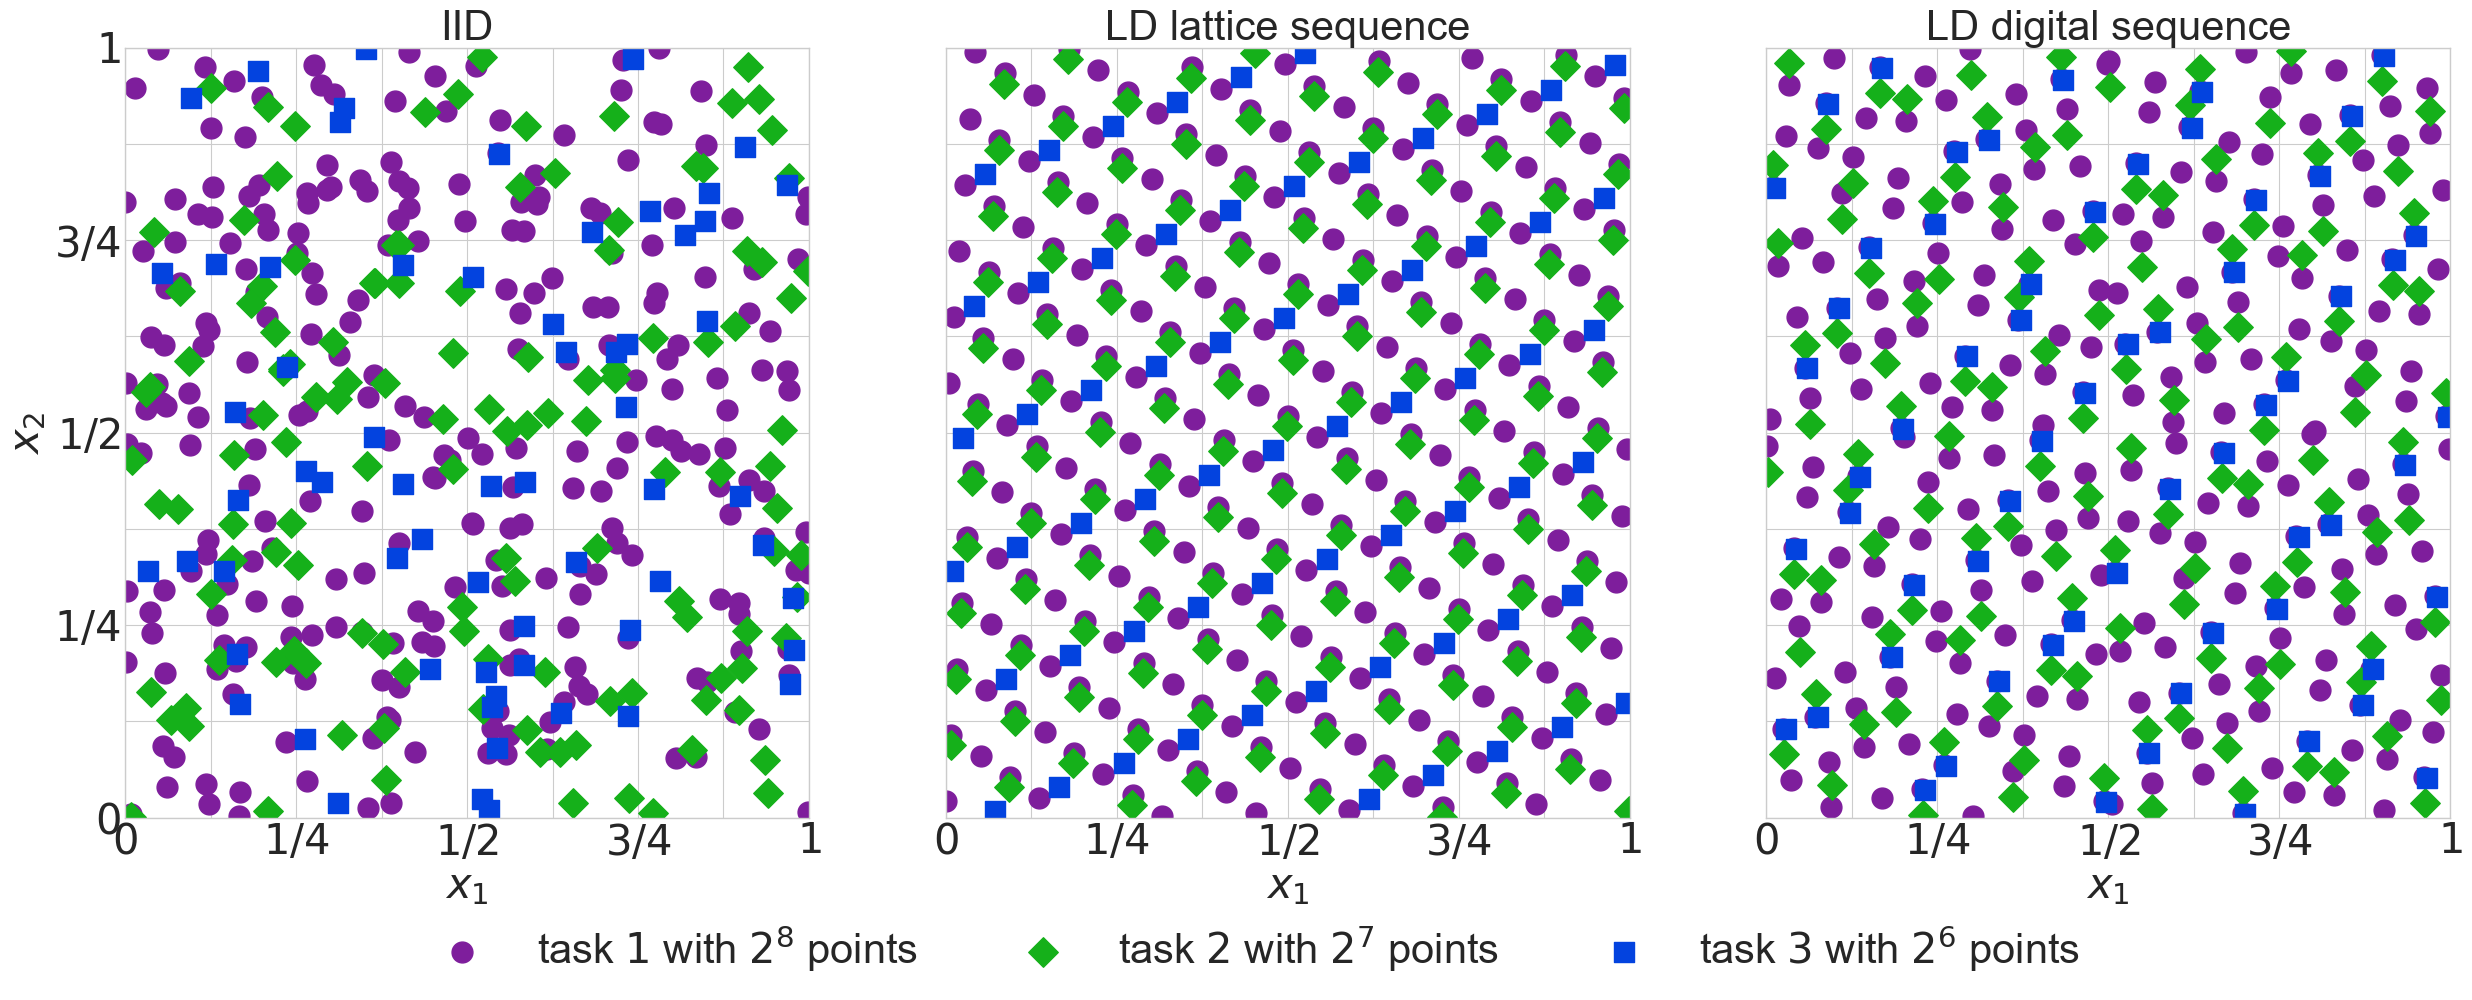

In [2]:
n = np.array([2**8,2**7,2**6],dtype=int)
assert np.all(np.log2(n)%1==0)
levels = len(n)
n_max = n.max()
point_sets = [
    ("IID",qp.IIDStdUniform(2,seed=11,replications=levels)(n_max)),
    ("LD lattice sequence",qp.Lattice(2,seed=5,replications=levels)(n_max)),
    ("LD digital sequence",qp.DigitalNet(2,seed=11,replications=levels,randomize="DS")(n_max)),
]
ncols = len(point_sets)
fig,ax = pyplot.subplots(nrows=1,ncols=ncols,figsize=(PW,PW/ncols),sharex=True,sharey=True)
for i in range(ncols):
    name,x = point_sets[i]
    for r in range(levels):
        x_r = x[r,:n[r],:]
        ax[i].scatter(x_r[:,0],x_r[:,1],color=COLORS[r],marker=MARKERS[r],label=(r"task $%d$ with $2^{%d}$ points"%(r+1,int(np.log2(n[r]))) if i==0 else None))
    ax[i].set_title(name)
    ax[i].set_xlabel(r"$x_1$");
ax[0].set_ylabel(r"$x_2$")
ax[0].set_xlim([0,1]); ax[0].set_xticks([0,1/8,1/4,3/8,1/2,5/8,3/4,7/8,1]); ax[0].set_xticklabels([r"$0$","",r"$1/4$","",r"$1/2$","",r"$3/4$","",r"$1$"])
ax[0].set_ylim([0,1]); ax[0].set_yticks([0,1/8,1/4,3/8,1/2,5/8,3/4,7/8,1]); ax[0].set_yticklabels([r"$0$","",r"$1/4$","",r"$1/2$","",r"$3/4$","",r"$1$"])
fig.legend(loc="lower center",ncols=levels,bbox_to_anchor=(1/2,-1/12))
fig.savefig("./points.pdf",bbox_inches="tight")

## Problems

In [3]:
def currin(level, x): # https://www.sfu.ca/~ssurjano/curretal88exp.html
    assert x.size(-1)==2 
    assert level in [0,1]
    x1,x2 = x[...,0],x[...,1]
    f = lambda x1,x2: (1-torch.exp(-1/(2*x2)))*(2300*x1**3+1900*x1**2+2092*x1+60)/(100*x1**3+500*x1**2+4*x1+20)
    if level==0:
        y = 1/4*(f(x1+0.05,x2+0.05)+f(x1+0.05,torch.maximum(torch.zeros(1),x2-0.05))+f(x1-0.05,x2+0.05)+f(x1-0.05,torch.maximum(torch.zeros(1),x2-0.05)))
    else:
        y = f(x1,x2)
    return y

def park1(level, x): # https://www.sfu.ca/~ssurjano/park91a.html
    assert x.size(-1)==4 
    assert level in [0,1]
    x1,x2,x3,x4 = x[...,0],x[...,1],x[...,2],x[...,3]
    y = x1/2*(torch.sqrt(1+(x2+x3**2)*x4/x1**2)-1)+(x1+3*x4)*torch.exp(1+torch.sin(x3))
    if level==0:
        y = (1+torch.sin(x1)/10)*y-2*x1+x2**2+x3**2+0.5
    return y 

def park2(level, x): # https://www.sfu.ca/~ssurjano/park91b.html
    assert x.size(-1)==4 
    assert level in [0,1]
    x1,x2,x3,x4 = x[...,0],x[...,1],x[...,2],x[...,3]
    y = 2/3*torch.exp(x1+x2)-x4*torch.sin(x3)+x3
    if level==0:
        y = 1.2*y-1
    return y 

def borehole(level, x): # https://www.sfu.ca/~ssurjano/borehole.html
    assert level in [0,1]
    assert x.size(-1)==8
    x = x.numpy()
    import scipy.stats
    rw = torch.from_numpy(scipy.stats.norm(loc=0.10,scale=0.0161812).ppf(x[...,0]))
    r  = torch.from_numpy(scipy.stats.lognorm(scale=np.exp(7.71),s=1.0056).ppf(x[...,1]))
    Tu = torch.from_numpy(scipy.stats.uniform(loc=63070,scale=115600-63070).ppf(x[...,2]))
    Hu = torch.from_numpy(scipy.stats.uniform(loc=990,scale=1110-990).ppf(x[...,3]))
    Tl = torch.from_numpy(scipy.stats.uniform(loc=63.1,scale=116-63.1).ppf(x[...,4]))
    Hl = torch.from_numpy(scipy.stats.uniform(loc=700,scale=820-700).ppf(x[...,5]))
    L  = torch.from_numpy(scipy.stats.uniform(loc=1120,scale=1680-1120).ppf(x[...,6]))
    Kw = torch.from_numpy(scipy.stats.uniform(loc=9855,scale=12045-9855).ppf(x[...,7]))
    C1 = 5 if level==0 else 2
    C2 = 1.5 if level==0 else 1
    frac1 = C1 * torch.pi * Tu * (Hu-Hl)
    frac2a = 2*L*Tu / (torch.log(r/rw)*rw**2*Kw)
    frac2b = Tu / Tl
    frac2 = torch.log(r/rw) * (C2+frac2a+frac2b)
    y = frac1 / frac2
    return y

def elliptic(level, x):
    assert x.shape[-1]==16
    from scipy.sparse import diags
    from scipy.sparse.linalg import spsolve
    from scipy.stats import norm
    coeffs = x.numpy()
    # Define grid
    N = 2 ** (level + 2)  # Number of intervals
    h = 1.0 / N  # Mesh spacing
    x = np.linspace(h, 1 - h, N - 1)  # Interior points
    # Compute diffusion coefficient a(x)
    coeffs = np.random.rand(8) if coeffs is None else coeffs
    assert isinstance(coeffs,np.ndarray)
    coeffs = norm.ppf(coeffs)  # Transform from uniform to iid Gaussian
    batch_shape = list(coeffs.shape)[:-1]
    k = np.arange(1,coeffs.shape[-1]+1)
    a_x = np.exp((coeffs[...,None] / k[:,None]  *np.sin(np.pi * k[:,None] * x)).sum(-2))
    # Compute a at half-grid points (needed for flux terms)
    a_half = np.zeros(batch_shape+[N])
    a_half[...,1:-1] = (a_x[...,:-1] + a_x[...,1:]) / 2  # Midpoint values for flux approximation
    a_half[...,0] = a_x[...,0]  # At the first midpoint
    a_half[...,-1] = a_x[...,-1]  # At the last midpoint
    # Construct the finite difference matrix
    lower_diag = -a_half[...,1:-1] / h**2
    upper_diag = -a_half[...,1:-1] / h**2
    main_diag = (a_half[...,:-1] + a_half[...,1:]) / h**2
    # Right-hand side (forcing term)
    b = np.ones([N-1])  # Constant source term (1)
    def _spsolve(main_diag, upper_diag, lower_diag, b):
        N = main_diag.shape[-1]
        assert main_diag.shape==(N,) and upper_diag.shape==(N-1,) and lower_diag.shape==(N-1,) and b.shape==(N,)
        A = diags([main_diag, upper_diag, lower_diag],[0, 1, -1],shape=[N,N],format="csc",)
        u = spsolve(A, b)
        return u
    vec_spsolve = np.vectorize(_spsolve,signature="(n),(m),(m),(n)->(n)")
    u = vec_spsolve(main_diag, upper_diag, lower_diag, b)
    # Find index closest to x = 0.5
    idx = np.argmin(np.abs(x - 0.5))
    # return u[...,idx], u, x, a_x, x[idx]
    return torch.from_numpy(u[...,idx])

def asian_option(level, x):
    assert level>=0
    d = 2**(level+1)
    assert x.size(-1)>=d
    ao = qp.FinancialOption(
        qp.IIDStdUniform(d),
        option = "ASIAN",
        call_put = "CALL",
        asian_mean = "GEOMETRIC",
        asian_mean_quadrature_rule = "RIGHT",
        volatility = 0.2, 
        start_price = 100, 
        strike_price = 100, 
        interest_rate = 0.05, 
        t_final = 1, 
    )
    y = torch.from_numpy(ao.f(x[...,:d].numpy()))
    return y

In [29]:
def fit_gps(func, d, levels, n, iterations, xtest, fit_std_gp, fit_gpytorch_gp, fit_fgpdnet, fit_fgplat):
    assert n.shape==(levels,)
    seqs_dnet = [qp.DigitalNet(dimension=d,randomize="DS") for l in range(levels)]
    xs_dnet = [torch.from_numpy(seqs_dnet[l](n[l])) for l in range(levels)]
    ys_dnet = [func(l,xs_dnet[l]) for l in range(levels)]
    times = []
    yhattests = []
    muhats = []
    if fit_std_gp: # standard GP
        gp = fastgps.StandardGP(kernel=qp.KernelMultiTask(base_kernel=qp.KernelSquaredExponential(d=d,torchify=True),num_tasks=levels),seqs=seqs_dnet)
        gp.add_y_next(ys_dnet)
        t0 = time.perf_counter()
        data = gp.fit(iterations=iterations,verbose=0,store_hists=True)
        times.append((time.perf_counter()-t0)/len(data["iteration"]))
        yhattests.append(gp.post_mean(xtest,task=levels-1))
        muhats.append(gp.post_cubature_mean(task=levels-1))
    if fit_gpytorch_gp: # GPyTorch Multitask GP https://docs.gpytorch.ai/en/v1.6.0/examples/03_Multitask_Exact_GPs/Hadamard_Multitask_GP_Regression.html
        import gpytorch
        class MultitaskGPModel(gpytorch.models.ExactGP):
            def __init__(self, train_x, train_y, likelihood):
                super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
                self.mean_module = gpytorch.means.ZeroMean()
                self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=d))
                self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=levels,rank=levels)
            def forward(self,x,i):
                mean_x = self.mean_module(x)
                covar_x = self.covar_module(x)
                covar_i = self.task_covar_module(i)
                covar = covar_x.mul(covar_i)
                return gpytorch.distributions.MultivariateNormal(mean_x,covar)
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        _full_train_i = torch.cat([l*torch.ones((n[l],1),dtype=int) for l in range(levels)])
        _full_train_x = torch.cat(xs_dnet)
        _full_train_y = torch.cat(ys_dnet)
        gpt = MultitaskGPModel((_full_train_x,_full_train_i),_full_train_y, likelihood)
        gpt.train()
        likelihood.train()
        # optimizer = torch.optim.Adam(gpt.parameters(), lr=0.1)
        optimizer = torch.optim.Rprop(gpt.parameters(), lr=0.1)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,gpt)
        t0 = time.perf_counter()
        for i in range(iterations):
            optimizer.zero_grad()
            output = gpt(_full_train_x,_full_train_i)
            loss = -mll(output, _full_train_y)
            loss.backward()
            optimizer.step()
        times.append((time.perf_counter()-t0)/iterations)
        gpt.eval()
        likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            gpt_yhattest = gpt(xtest,(levels-1)*torch.ones((xtest.size(0),1),dtype=int)).mean
        yhattests.append(gpt_yhattest)
        muhats.append(gpt_yhattest.mean()) # cannot exactly compute the mean, so just take a QMC estimate
    if fit_fgpdnet: # fast GP Dnet 
        fgp = fastgps.FastGPDigitalNetB2(kernel=qp.KernelMultiTask(base_kernel=qp.KernelDigShiftInvarAdaptiveAlpha(d=d,torchify=True),num_tasks=levels),seqs=seqs_dnet)
        fgp.add_y_next(ys_dnet)
        t0 = time.perf_counter()
        data = fgp.fit(iterations=iterations,verbose=0,store_hists=True)
        times.append((time.perf_counter()-t0)/len(data["iteration"]))
        yhattests.append(fgp.post_mean(xtest,task=levels-1))
        muhats.append(fgp.post_cubature_mean(task=levels-1))
    if fit_fgplat: # fast GP lattice
        seqs_lat = [qp.Lattice(dimension=d) for l in range(levels)]
        xs_lat = [torch.from_numpy(seqs_dnet[l](n[l])) for l in range(levels)]
        # ys_lat = [func(l,xs_lat[l]) for l in range(levels)]
        ys_lat = [func(l,1-2*torch.abs(xs_lat[l]-1/2)) for l in range(levels)]
        fgp = fastgps.StandardGP(kernel=qp.KernelMultiTask(base_kernel=qp.KernelShiftInvar(d=d,torchify=True,alpha=2),num_tasks=levels),seqs=seqs_lat)
        fgp.add_y_next(ys_lat)
        t0 = time.perf_counter()
        data = fgp.fit(iterations=iterations,verbose=0,store_hists=True)
        times.append((time.perf_counter()-t0)/len(data["iteration"]))
        # fgp_lat_yhattest = fgp.post_mean(xtest,task=levels-1)
        yhattests.append(1/2*(fgp.post_mean(xtest/2,task=levels-1)+fgp.post_mean(1-xtest/2,task=levels-1)))
        muhats.append(fgp.post_cubature_mean(task=levels-1))
    return torch.tensor(times),torch.stack(yhattests,dim=0),torch.stack(muhats,dim=0)

def run(name, func, d, levels, ns, iterations=100):
    assert ns.ndim==2 and ns.size(1)==levels
    num_ns = len(ns)
    xtest = torch.from_numpy(qp.Halton(dimension=d,randomize="QRNG",seed=11)(2**18))
    ytest = func(levels-1,xtest)
    for i in range(num_ns):
        n = ns[i]
        tpi,yhattest,muhat = fit_gps(func,d,levels,n,iterations,xtest[:2**12],fit_std_gp=True,fit_gpytorch_gp=True,fit_fgpdnet=True,fit_fgplat=True)
        l2rerrors = torch.linalg.norm(yhattest-ytest[:2**12],dim=-1)/torch.linalg.norm(ytest[:2**12])
        print(tpi)
        print(l2rerrors)
        print(muhat)
        print(ytest.mean())
        print()
run("TMP",park1,4,2,torch.tensor([[2**9,2**8]],dtype=int))

tensor([0.0429, 0.0185, 0.0039, 0.0602])
tensor([2.7917e-04, 3.9577e-04, 1.7341e-02, 4.8170e-01])
tensor([9.0321, 9.0306, 9.0239, 9.0197])
tensor(9.0321)



In [30]:
problems = [
    ("Currin",currin,2,2,),
    ("Park1",park1,4,2),
    ("Park2",park2,4,2),
    ("Borehole",borehole,8,2),
    ("Elliptic",elliptic,16,4),
    ("Asian option",asian_option,32,5)
]